In [1]:
# === 1) Imports ===
import numpy as np
import pandas as pd
import wfdb
import ast
from pathlib import Path
import joblib

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [2]:
# === 2) Set PTB-XL path ===
# Put the dataset folder path here.
# IMPORTANT: make sure it ends with a slash "/" (or use Pathlib).
PTBXL_PATH = "./ptbxl/"

SAMPLING_RATE = 100  # use records100 (faster)
RANDOM_STATE = 42

# Where to save/load trained model artifacts
ARTIFACT_DIR = Path('./artifacts')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
# === 3) Load metadata and labels ===
Y = pd.read_csv(PTBXL_PATH + "ptbxl_database.csv", index_col="ecg_id")
Y["scp_codes"] = Y["scp_codes"].apply(ast.literal_eval)

agg_df = pd.read_csv(PTBXL_PATH + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df["diagnostic"] == 1]

def aggregate_diagnostic(y_dic):
    out = []
    for key in y_dic.keys():
        if key in agg_df.index:
            out.append(agg_df.loc[key, "diagnostic_class"])
    return list(set(out))

Y["diagnostic_superclass"] = Y["scp_codes"].apply(aggregate_diagnostic)

Y[["patient_id","sex","age","strat_fold","diagnostic_superclass"]].head()


,patient_id,sex,age,strat_fold,diagnostic_superclass
ecg_id,,,,,
1,15709.0,1,56.0,3,[NORM]
2,13243.0,0,19.0,2,[NORM]
3,20372.0,1,37.0,5,[NORM]
4,17014.0,0,24.0,3,[NORM]
5,17448.0,1,19.0,4,[NORM]


In [4]:
# === 4) Load raw ECG waveforms (WFDB) ===
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        files = df["filename_lr"].values
    else:
        files = df["filename_hr"].values
    data = [wfdb.rdsamp(path + f)[0] for f in files]  # only signal array
    return np.array(data, dtype=object)  # each element is (time, 12)

X = load_raw_data(Y, SAMPLING_RATE, PTBXL_PATH)
print("Loaded records:", len(X), "Example shape:", X[0].shape)


Loaded records: 21837 Example shape: (1000, 12)


In [5]:
xflat = np.array([x.flatten() for x in X])  # flatten 2D arrays to 1D
xflat

array([[-0.119, -0.055, 0.064, ..., 0.143, -0.035, -0.12],
       [0.004, 0.138, 0.134, ..., -0.308, -0.231, -0.145],
       [-0.029, -0.079, -0.049, ..., 0.001, -0.018, 0.006],
       ...,
       [0.038, 0.024, -0.014, ..., -0.181, -0.105, 0.033],
       [-0.057, -0.057, 0.0, ..., 0.211, 0.374, -0.009],
       [-0.049, -0.025, 0.024, ..., 0.106, 0.047, -0.103]],
      shape=(21837, 12000), dtype=object)

In [6]:
# === 5) Split (PTB-XL recommended) ===
# folds 1-8 train, fold 9 val, fold 10 test
train_idx = np.where(Y["strat_fold"].between(1, 8))[0]
val_idx   = np.where(Y["strat_fold"] == 9)[0]
test_idx  = np.where(Y["strat_fold"] == 10)[0]

X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train_list = Y.iloc[train_idx]["diagnostic_superclass"]
y_val_list   = Y.iloc[val_idx]["diagnostic_superclass"]
y_test_list  = Y.iloc[test_idx]["diagnostic_superclass"]

print("Train/Val/Test:", len(train_idx), len(val_idx), len(test_idx))


Train/Val/Test: 17441 2193 2203


In [7]:
# === 6) Choose a simple target (binary) ===
# Example: detect Myocardial Infarction (MI) vs not MI
TARGET = "MI"

y_train = y_train_list.apply(lambda labels: int(TARGET in labels)).to_numpy()
y_val   = y_val_list.apply(lambda labels: int(TARGET in labels)).to_numpy()
y_test  = y_test_list.apply(lambda labels: int(TARGET in labels)).to_numpy()

print("Positive rate (train):", y_train.mean())


Positive rate (train): 0.251648414655123


In [8]:
# === 7) Feature extraction (fast baseline) ===
# For each lead we compute 5 simple features: mean, std, min, max, RMS.
def feats_one_lead(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return [0,0,0,0,0]
    return [x.mean(), x.std(), x.min(), x.max(), np.sqrt(np.mean(x**2))]

def feats_ecg(ecg):
    # ecg: (time, leads)
    ecg = np.asarray(ecg, dtype=float)
    out = []
    for lead in range(ecg.shape[1]):
        out.extend(feats_one_lead(ecg[:, lead]))
    return np.array(out, dtype=float)

X_train_feat = np.vstack([feats_ecg(e) for e in X_train])
X_val_feat   = np.vstack([feats_ecg(e) for e in X_val])
X_test_feat  = np.vstack([feats_ecg(e) for e in X_test])

print("Feature matrix:", X_train_feat.shape)


Feature matrix: (17441, 60)


No cached model found — training now...
VAL ROC-AUC: 0.8140974476509828
VAL Brier score: 0.1400071869650429
Chosen threshold: 0.21699906795887078
Saved model artifact to: artifacts\ptbxl_gbcal_MI_sr100.joblib
VAL ROC-AUC (post-load): 0.8140974476509828
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1649
           1       0.45      0.80      0.57       544

    accuracy                           0.70      2193
   macro avg       0.68      0.74      0.67      2193
weighted avg       0.80      0.70      0.72      2193

Confusion matrix:
 [[1106  543]
 [ 108  436]]


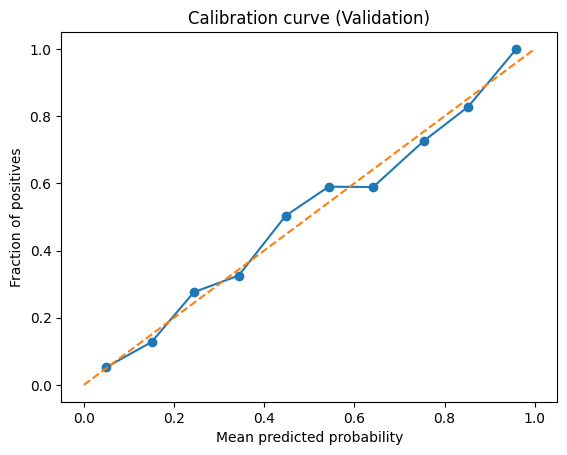

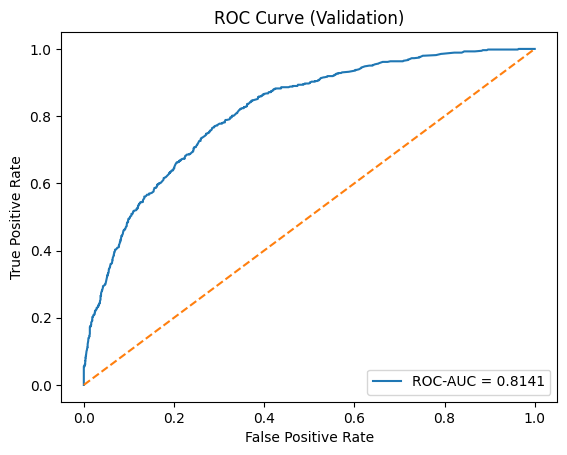

In [9]:
# === 8) Train OR load a calibrated probability model ===
# This cell now caches the trained model + selected threshold to disk.
# If the artifact exists, training is skipped and the model is loaded.

import sklearn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)

MODEL_PATH = ARTIFACT_DIR / f"ptbxl_gbcal_{TARGET}_sr{SAMPLING_RATE}.joblib"

# -----------------------
# Define model (architecture/params) deterministically
# -----------------------
base_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        n_estimators=206,
        learning_rate=0.10618101782710437,
        max_depth=2,
        min_samples_leaf=20,
    )),
])

cal_model = CalibratedClassifierCV(
    estimator=base_model,
    method="isotonic",  # use "sigmoid" for simpler calibration if desired
    cv=3,
)

# -----------------------
# Load if available, else train and save
# -----------------------
if MODEL_PATH.exists():
    bundle = joblib.load(MODEL_PATH)
    best_model = bundle["model"]
    chosen_threshold = float(bundle["threshold"])
    print(f"Loaded cached model from: {MODEL_PATH}")
    print(f"Cached threshold: {chosen_threshold:.6f}")
    print("Cached metadata:", {k: bundle[k] for k in bundle.keys() if k not in ('model', 'threshold')})
else:
    print("No cached model found — training now...")
    best_model = cal_model.fit(X_train_feat, y_train)

    # Validation probabilities (calibrated)
    val_prob = best_model.predict_proba(X_val_feat)[:, 1]
    print("VAL ROC-AUC:", roc_auc_score(y_val, val_prob))
    print("VAL Brier score:", brier_score_loss(y_val, val_prob))

    # Choose threshold (example: recall >= 0.80)
    prec, rec, thr = precision_recall_curve(y_val, val_prob)
    thr = np.r_[thr, 1.0]
    MIN_RECALL = 0.80
    mask = rec >= MIN_RECALL
    if not np.any(mask):
        raise ValueError("No threshold achieves the requested MIN_RECALL.")
    chosen_threshold = float(thr[mask][np.argmax(prec[mask])])
    print("Chosen threshold:", chosen_threshold)

    # Save model + threshold together so inference is fully reproducible
    bundle = {
        "model": best_model,
        "threshold": chosen_threshold,
        "target": TARGET,
        "sampling_rate": SAMPLING_RATE,
        "random_state": RANDOM_STATE,
        "sklearn_version": sklearn.__version__,
    }
    joblib.dump(bundle, MODEL_PATH)
    print(f"Saved model artifact to: {MODEL_PATH}")

# -----------------------
# Minimal validation to confirm the loaded/trained model works
# -----------------------
val_prob = best_model.predict_proba(X_val_feat)[:, 1]
print("VAL ROC-AUC (post-load):", roc_auc_score(y_val, val_prob))

val_pred = (val_prob >= chosen_threshold).astype(int)
print(classification_report(y_val, val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# -----------------------
# Optional diagnostics plots (can comment out if running headless)
# -----------------------
frac_pos, mean_pred = calibration_curve(y_val, val_prob, n_bins=10)

plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve (Validation)")
plt.show()

fpr, tpr, _ = roc_curve(y_val, val_prob)
auc = roc_auc_score(y_val, val_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.show()


In [10]:
# === 9) Final evaluation on the held-out test fold ===
# Uses the cached (or newly trained) model + the persisted threshold.

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

test_prob = best_model.predict_proba(X_test_feat)[:, 1]
print("TEST ROC-AUC:", roc_auc_score(y_test, test_prob))

test_pred = (test_prob >= chosen_threshold).astype(int)
print(classification_report(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))


TEST ROC-AUC: 0.7948035508795004
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1650
           1       0.42      0.76      0.54       553

    accuracy                           0.68      2203
   macro avg       0.66      0.71      0.65      2203
weighted avg       0.77      0.68      0.70      2203

Confusion matrix:
 [[1079  571]
 [ 134  419]]
